**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.port,33427
spark.sql.warehouse.dir,file:/users/home/jji61/spark-warehouse
spark.driver.memory,4g
spark.app.name,jji61 (jupyter)
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/jji61/spark/
spark.executor.cores,2


In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import count, regexp_extract, col, regexp_replace, rand, explode
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, ArrayType, IntegerType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.window import Window
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RankingEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
from pyspark.ml.recommendation import ALS
import os
from pyspark.sql import Row
import matplotlib.colors as mcolors

# Data processing

## Q1

### (a)

In [6]:
! hdfs dfs -ls hdfs:///data/msd/

Found 4 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/audio
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/genre
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 hdfs:///data/msd/main
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/tasteprofile


In [8]:
! hdfs dfs -ls hdfs:///data/msd/audio

Found 3 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/audio/attributes
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/audio/features
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 hdfs:///data/msd/audio/statistics


In [9]:
! hdfs dfs -ls hdfs:///data/msd/genre

Found 3 items
-rw-r--r--   8 jsw93 supergroup   11625230 2021-09-29 10:35 hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv
-rw-r--r--   8 jsw93 supergroup    8820054 2021-09-29 10:35 hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv
-rw-r--r--   8 jsw93 supergroup   11140605 2021-09-29 10:35 hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv


In [10]:
! hdfs dfs -ls hdfs:///data/msd/main

Found 1 items
drwxr-xr-x   - jsw93 supergroup          0 2022-05-23 12:11 hdfs:///data/msd/main/summary


In [11]:
! hdfs dfs -ls hdfs:///data/msd/tasteprofile

Found 2 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/tasteprofile/mismatches
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/tasteprofile/triplets.tsv


In [12]:
! hdfs dfs -ls hdfs:///data/msd/audio/attributes
! hdfs dfs -ls hdfs:///data/msd/audio/features
! hdfs dfs -ls hdfs:///data/msd/audio/statistics

Found 13 items
-rw-r--r--   8 jsw93 supergroup       1051 2021-09-29 10:35 hdfs:///data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        671 2021-09-29 10:35 hdfs:///data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        484 2021-09-29 10:35 hdfs:///data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        898 2021-09-29 10:35 hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 hdfs:///data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 hdfs:///data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup      12317 2021-09-29 10:35 hdfs:///data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
-rw-r--

In [13]:
! hdfs dfs -ls hdfs:///data/msd/main/summary 

Found 2 items
-rw-r--r--   8 jsw93 supergroup   58658141 2021-09-29 10:28 hdfs:///data/msd/main/summary/analysis.csv.gz
-rw-r--r--   8 jsw93 supergroup  124211304 2021-09-29 10:28 hdfs:///data/msd/main/summary/metadata.csv.gz


In [14]:
! hdfs dfs -ls hdfs:///data/msd/tasteprofile/mismatches

Found 2 items
-rw-r--r--   8 jsw93 supergroup      91342 2021-09-29 10:35 hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt
-rw-r--r--   8 jsw93 supergroup    2026182 2021-09-29 10:35 hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt


In [17]:
! hdfs dfs -du -h hdfs:///data/msd/audio/attributes

1.0 K   8.2 K    hdfs:///data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
671     5.2 K    hdfs:///data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
484     3.8 K    hdfs:///data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
898     7.0 K    hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
777     6.1 K    hdfs:///data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
777     6.1 K    hdfs:///data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
12.0 K  96.2 K   hdfs:///data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
9.8 K   78.0 K   hdfs:///data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv
1.4 K   10.9 K   hdfs:///data/msd/audio/attributes/msd-rh-v1.0.attributes.csv
34.1 K  272.8 K  hdfs:///data/msd/audio/attributes/msd-rp-v1.0.attributes.csv
3.8 K   30.8 K   hdfs:///data/msd/audio/attributes/msd-ssd-v1.0.attributes.csv
9.8 K   7

In [18]:
! hdfs dfs -du -h hdfs:///data/msd/audio/features

65.5 M   524.2 M  hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
53.1 M   424.6 M  hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
35.8 M   286.5 M  hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
70.8 M   566.1 M  hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
51.1 M   408.9 M  hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
51.1 M   408.9 M  hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
412.2 M  3.2 G    hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
1.3 G    10.3 G   hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv
240.3 M  1.9 G    hdfs:///data/msd/audio/features/msd-rh-v1.0.csv
4.0 G    32.3 G   hdfs:///data/msd/audio/features/msd-rp-v1.0.csv
640.6 M  5.0 G    hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv
1.4 G    11.5 G   hdfs:///data/msd/audio/features/msd-trh-v1.0.csv
3.9 G    31.0 G   hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv


In [19]:
! hdfs dfs -du -h hdfs:///data/msd/audio/statistics

40.3 M  322.1 M  hdfs:///data/msd/audio/statistics/sample_properties.csv.gz


In [20]:
! hdfs dfs -du -h hdfs:///data/msd/genre

11.1 M  88.7 M  hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv
8.4 M   67.3 M  hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv
10.6 M  85.0 M  hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv


In [21]:
! hdfs dfs -du -h hdfs:///data/msd/main/summary 

55.9 M   447.5 M  hdfs:///data/msd/main/summary/analysis.csv.gz
118.5 M  947.7 M  hdfs:///data/msd/main/summary/metadata.csv.gz


In [22]:
! hdfs dfs -du -h hdfs:///data/msd/tasteprofile

2.0 M    16.2 M  hdfs:///data/msd/tasteprofile/mismatches
488.4 M  3.8 G   hdfs:///data/msd/tasteprofile/triplets.tsv


In [23]:
! hdfs dfs -du -h hdfs:///data/msd/tasteprofile/mismatches

89.2 K  713.6 K  hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt
1.9 M   15.5 M   hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt


In [106]:
# List of directories to process
directories = [
    "hdfs:///data/msd/audio/attributes/",
    "hdfs:///data/msd/audio/features",
    "hdfs:///data/msd/audio/statistics",
    "hdfs:///data/msd/genre/",
    "hdfs:///data/msd/main/summary/",
    "hdfs:///data/msd/tasteprofile",
    "hdfs:///data/msd/tasteprofile/mismatches"
]

# Initialize a dictionary to store unique data types for each directory
dir_unique_data_types = {}

for dir_path in directories:
    print(f"\nProcessing directory: {dir_path}")

    # Use Python formatting to create the command
    cmd = f"hdfs dfs -ls {dir_path} | awk '{{print $8}}'"

    # Execute the shell command using the os module
    file_list = os.popen(cmd).read().splitlines()

    unique_data_types_for_dir = set()

    for file_path in file_list:
        if not file_path:  # Check to skip empty file paths
            continue

        try:
            # Read the file
            data = spark.read.csv(file_path, inferSchema=True)
            
            # Collect unique data types from the file's schema
            for field in data.schema.fields:
                unique_data_types_for_dir.add(str(field.dataType))
        
        except Exception as e:
            print(f"Error reading file {file_path}: {str(e)}")
    
    # Store the unique data types for this directory
    dir_unique_data_types[dir_path] = unique_data_types_for_dir

# Print the unique data types for each directory
print("\nUnique data types for each directory:")
for dir_path, data_types in dir_unique_data_types.items():
    print(f"\n{dir_path}:")
    for dtype in data_types:
        print(dtype)



Processing directory: hdfs:///data/msd/audio/attributes/

Processing directory: hdfs:///data/msd/audio/features

Processing directory: hdfs:///data/msd/audio/statistics

Processing directory: hdfs:///data/msd/genre/

Processing directory: hdfs:///data/msd/main/summary/

Processing directory: hdfs:///data/msd/tasteprofile

Processing directory: hdfs:///data/msd/tasteprofile/mismatches

Unique data types for each directory:

hdfs:///data/msd/audio/attributes/:
StringType

hdfs:///data/msd/audio/features:
DoubleType
StringType

hdfs:///data/msd/audio/statistics:
StringType

hdfs:///data/msd/genre/:
StringType

hdfs:///data/msd/main/summary/:
StringType

hdfs:///data/msd/tasteprofile:
StringType

hdfs:///data/msd/tasteprofile/mismatches:
StringType


### (b)

In [8]:
def count_rows_in_directory(dir_path, row_counts):
    files_in_directory = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()) \
                            .listStatus(spark._jvm.org.apache.hadoop.fs.Path(dir_path))
    for file_status in files_in_directory:
        path_str = file_status.getPath().toString()
        if file_status.isDirectory():
            count_rows_in_directory(path_str, row_counts)  # Recursively explore directory
        else:
            df = spark.read.csv(path_str, inferSchema=True)  
            row_count = df.agg(count("*")).collect()[0][0]
            row_counts[path_str] = row_count

row_counts = {}

for dir_name in directories:
    dir_path = base_dir + dir_name
    count_rows_in_directory(dir_path, row_counts)
    files_in_directory = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()) \
                            .listStatus(spark._jvm.org.apache.hadoop.fs.Path(dir_path))
    for file_status in files_in_directory:
        if not file_status.isDirectory():  # Only count rows in files, not directories
            file_path = file_status.getPath().toString()
            df = spark.read.csv(file_path, inferSchema=True)  
            row_count = df.agg(count("*")).collect()[0][0]
            row_counts[file_path] = row_count

# Count rows for the main dataset which contains unique songs
unique_songs_path = base_dir + "main/summary"
unique_songs_df = spark.read.csv(unique_songs_path, header=True, inferSchema=True)
unique_songs_count = unique_songs_df.select("song_id").distinct().count()


# Output the results
for key, value in row_counts.items():
    print(f"File {key} has {value} rows.")
print(f"\nThe total number of unique songs in the dataset is: {unique_songs_count}")




File hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv has 21 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv has 21 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv has 11 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv has 27 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv has 17 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv has 17 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv has 125 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv has 421 rows.
File hdfs://masternode2:9000/data/msd/audio/attributes/msd-rh-v1.0.attributes.csv has 61 rows.
File hdfs:/

## Q2

### (a)

In [4]:
sid_mismatches_df = spark.read.csv("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt", header=False, sep="\t")
sid_matches_manually_accepted_df = spark.read.csv("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt", header=False, sep="\t")

In [5]:
sid_mismatches_df.limit(10).show(truncate=False)
sid_matches_manually_accepted_df.limit(10).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0                                                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground              |
|ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It|
|ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E> Africa HiTech  -  Footstep  !=  Marcus Worgull  -  Drumstern (BONUS TRACK)                            |
|ERROR: <SONGHTM12A8C1374EF TRMMITP128F425D8D0> Death in Vegas  -  Anita Berber  !=  Val

In [6]:
mismatches_schema = StructType([
    StructField("song_id", StringType(), True),
    StructField("song_artist", StringType(), True),
    StructField("song_title", StringType(), True),
    StructField("track_id", StringType(), True),
    StructField("track_artist", StringType(), True),
    StructField("track_title", StringType(), True)
])

In [7]:
# Read the file from HDFS
matches_manually_accepted_rdd = spark.sparkContext.textFile("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt")

# Function to process each line of the file
def process_line(line):
    if line.startswith("< ERROR: "):
        a = line[10:28]
        b = line[29:47]
        c, d = line[49:-1].split("  !=  ")
        e, f = c.split("  -  ")
        g, h = d.split("  -  ")
        return (a, e, f, b, g, h)

# Filter and transform the RDD using the process_line function
processed_rdd = matches_manually_accepted_rdd.filter(lambda line: line.startswith("< ERROR: ")).map(process_line)

# Convert the RDD to a DataFrame
matches_manually_accepted = spark.createDataFrame(processed_rdd, schema=mismatches_schema)


In [8]:
show_as_html(matches_manually_accepted)
matches_manually_accepted.count()

,song_id,song_artist,song_title,track_id,track_artist,track_title
0,SOFQHZM12A8C142342,Josipa Lisac,razloga,TRMWMFG128F92FFEF2,Lisac Josipa,1000 razlog
1,SODXUTF12AB018A3DA,Lutan Fyah,Nuh Matter the Crisis Feat. Midnite,TRMWPCD12903CCE5ED,Midnite,Nah Matter the Crisi
2,SOASCRF12A8C1372E6,Gaetano Donizetti,L'Elisir d'Amore: Act Two: Come sen va contento!,TRMHIPJ128F426A2E2,Gianandrea Gavazzeni_ Orchestra E Coro Del Mag...,L'Elisir D'Amore_ Act 2: Come Sen Va Contento ...
3,SOITDUN12A58A7AACA,C.J. Chenier,"Ay, Ai Ai",TRMHXGK128F42446AB,Clifton Chenier,Ay_ Ai A
4,SOLZXUM12AB018BE39,許志安,男人最痛,TRMRSOF12903CCF516,Andy Hui,Nan Ren Zui Ton
5,SOTJTDT12A8C13A8A6,S,h,TRMNKQE128F427C4D8,Sammy Hagar,20th Century Man (Live
6,SOGCVWB12AB0184CE2,H,Y,TRMUNCZ128F932A95D,Hawkwind,25 Years (Alternate Mix
7,SOKDKGD12AB0185E9C,影山ヒロノブ,Cha-La Head-Cha-La (2005 ver./DRAGON BALL Z Op...,TRMOOAH12903CB4B29,Takahashi Hiroki,Maka fushigi adventure! (2005 Version/DRAGON B...
8,SOPPBXP12A8C141194,Αντώνης Ρέμος,O Trellos - Live,TRMXJDS128F42AE7CF,Antonis Remos,O Trello
9,SODQSLR12A8C133A01,John Williams,Concerto No. 1 for Guitar and String Orchestra...,TRWHMXN128F426E03C,English Chamber Orchestra,II. Andantino siciliano from Concerto No. 1 fo...


488

In [9]:
# Read the mismatches file from HDFS
mismatches_rdd = spark.sparkContext.textFile("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")

# Function to process each line of the mismatches file
def process_line_mismatches(line):
    if line.startswith("ERROR: "):
        a = line[8:26]
        b = line[27:45]
        c, d = line[47:-1].split("  !=  ")
        e, f = c.split("  -  ")
        g, h = d.split("  -  ")
        return (a, e, f, b, g, h)

# Filter and transform the RDD using the process_line_mismatches function
processed_mismatches_rdd = mismatches_rdd.filter(lambda line: line.startswith("ERROR: ")).map(process_line_mismatches)

# Convert the RDD to a DataFrame
mismatches = spark.createDataFrame(processed_mismatches_rdd, schema=mismatches_schema)

In [10]:
show_as_html(mismatches)
mismatches.count()

,song_id,song_artist,song_title,track_id,track_artist,track_title
0,SOUMNSI12AB0182807,Digital Underground,The Way We Swing,TRMMGKQ128F9325E10,Linkwood,Whats up with the Undergroun
1,SOCMRBE12AB018C546,Jimmy Reed,The Sun Is Shining (Digitally Remastered),TRMMREB12903CEB1B1,Slim Harpo,I Got Love If You Want I
2,SOLPHZY12AC468ABA8,Africa HiTech,Footstep,TRMMBOC12903CEB46E,Marcus Worgull,Drumstern (BONUS TRACK
3,SONGHTM12A8C1374EF,Death in Vegas,Anita Berber,TRMMITP128F425D8D0,Valen Hsu,Shi Y
4,SONGXCA12A8C13E82E,Grupo Exterminador,El Triunfador,TRMMAYZ128F429ECE6,I Ribelli,Lei M'Am
5,SOMBCRC12A67ADA435,Fading Friend,Get us out!,TRMMNVU128EF343EED,Masterboy,Feel The Heat 200
6,SOTDWDK12A8C13617B,Daevid Allen,Past Lives,TRMMNCZ128F426FF0E,Bhimsen Joshi,Raga - Shuddha Sarang_ Aala
7,SOEBURP12AB018C2FB,Cristian Paduraru,Born Again,TRMMPBS12903CE90E1,Yespiring,Journey Stage
8,SOSRJHS12A6D4FDAA3,Jeff Mills,Basic Human Design,TRMWMEL128F421DA68,M&T,Drumsetteste
9,SOIYAAQ12A6D4F954A,Excepter,OG,TRMWHRI128F147EA8E,The Fevers,Não Tenho Nada (Natchs Scheint Die Sonne


19094

In [11]:
# Load the full triplets dataset

schema_triplets = StructType([
    StructField("user_id", StringType(), True),
    StructField("song_id", StringType(), True),
    StructField("plays", IntegerType(), True)
])

triplets = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", "\t")
    .option("codec", "gzip")
    .schema(schema_triplets)
    .load("hdfs:///data/msd/tasteprofile/triplets.tsv/")
    .cache()
)

In [12]:
mismatches_not_accepted = mismatches.join(matches_manually_accepted, on="song_id", how="left_anti")
triplets_not_mismatched = triplets.join(mismatches_not_accepted, on="song_id", how="left_anti")

In [13]:
print(triplets.count())                 
print(triplets_not_mismatched.count())

48373586
45795111


### (b)

In [4]:
# Get list of files in the attributes directory
attribute_files = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration()) \
    .listStatus(spark._jvm.org.apache.hadoop.fs.Path("hdfs:///data/msd/audio/attributes/"))
attribute_files = [file.getPath().toString() for file in attribute_files if file.getPath().getName().endswith('.attributes.csv')]

In [5]:
unique_data_types = set()

for file_path in attribute_files:
    df = spark.read.csv(file_path, inferSchema=True)
    data_types_in_file = df.select("_c1").distinct().rdd.flatMap(lambda x: x).collect()
    unique_data_types.update(data_types_in_file)
    
print(unique_data_types)

{'real', 'NUMERIC', 'string', 'STRING'}


In [6]:
data_type_mapping = {
    'NUMERIC': DoubleType(),
    'STRING': StringType(),
    'string': StringType(),
    'real': DoubleType()
}

def get_schema_for_file(file_path):
    try:
        df_attributes = spark.read.csv(file_path, header=False)
        attributes_list = df_attributes.rdd.map(lambda row: (row._c0, row._c1)).collect()  
        schema = StructType([StructField(name, data_type_mapping.get(type_, StringType()), True) for name, type_ in attributes_list])
        return schema
    except Exception as e:
        print(f"Error processing file: {file_path}. Error: {str(e)}")
        return None

# Create a dictionary of schemas mapped to dataset prefixes
schemas = {}
for file_path in attribute_files:
    prefix = file_path.split("/")[-1].replace(".attributes.csv", "")
    schemas[prefix] = get_schema_for_file(file_path)

# Load each dataset in the features directory using its corresponding schema
feature_datasets = {}
for prefix, schema in schemas.items():
    dataset_path = f"hdfs:///data/msd/audio/features/{prefix}.csv"
    feature_datasets[prefix] = spark.read.csv(dataset_path, schema=schema)

In [7]:
print(feature_datasets)

{'msd-jmir-area-of-moments-all-v1.0': DataFrame[Area_Method_of_Moments_Overall_Standard_Deviation_1: double, Area_Method_of_Moments_Overall_Standard_Deviation_2: double, Area_Method_of_Moments_Overall_Standard_Deviation_3: double, Area_Method_of_Moments_Overall_Standard_Deviation_4: double, Area_Method_of_Moments_Overall_Standard_Deviation_5: double, Area_Method_of_Moments_Overall_Standard_Deviation_6: double, Area_Method_of_Moments_Overall_Standard_Deviation_7: double, Area_Method_of_Moments_Overall_Standard_Deviation_8: double, Area_Method_of_Moments_Overall_Standard_Deviation_9: double, Area_Method_of_Moments_Overall_Standard_Deviation_10: double, Area_Method_of_Moments_Overall_Average_1: double, Area_Method_of_Moments_Overall_Average_2: double, Area_Method_of_Moments_Overall_Average_3: double, Area_Method_of_Moments_Overall_Average_4: double, Area_Method_of_Moments_Overall_Average_5: double, Area_Method_of_Moments_Overall_Average_6: double, Area_Method_of_Moments_Overall_Average_7:

# Audio similarity

## Q1

### (a)

In [8]:
selected_dataset = feature_datasets['msd-jmir-methods-of-moments-all-v1.0']

In [9]:
show_as_html(selected_dataset)
selected_dataset.printSchema()

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID
0,0.15450,13.110,840.0,41080.0,7108000.0,0.3190,33.41,1371.0,64240.0,8398000.0,'TRHFHQZ12903C9E2D5'
1,0.11950,13.020,611.9,43880.0,7226000.0,0.2661,30.26,1829.0,183800.0,31230000.0,'TRHFHYX12903CAF953'
2,0.23260,7.185,362.2,19890.0,3030000.0,0.8854,32.68,1384.0,79190.0,9862000.0,'TRHFHAU128F9341A0E'
3,0.22830,10.300,463.8,24730.0,3336000.0,0.4321,37.56,2047.0,197200.0,32930000.0,'TRHFHLP128F14947A7'
4,0.18410,8.544,359.4,21900.0,3359000.0,0.8438,36.36,2008.0,205400.0,35390000.0,'TRHFHFF128F930AC11'
5,0.14600,8.248,519.4,42300.0,6138000.0,0.2782,19.08,1052.0,130900.0,22930000.0,'TRHFHYJ128F4234782'
6,0.09586,6.915,409.9,29840.0,4691000.0,0.2130,23.50,1140.0,81350.0,10120000.0,'TRHFHHR128F9339010'
7,0.08700,16.370,560.4,36280.0,4264000.0,0.1110,21.97,845.8,49790.0,6573000.0,'TRHFHMB128F4213BC9'
8,0.09981,7.871,550.9,46880.0,7261000.0,0.2457,14.07,841.5,104800.0,18470000.0,'TRHFHWT128F429032D'
9,0.23900,15.110,729.2,43200.0,6646000.0,0.4067,32.73,2045.0,175200.0,28720000.0,'TRHFHKO12903CBAF09'


root
 |-- Method_of_Moments_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_5: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_5: double (nullable = true)
 |-- MSD_TRACKID: string (nullable = true)



In [10]:
selected_dataset.count()

994623

In [11]:
show_as_html(selected_dataset.describe())

,summary,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,0.15498176001746336,10.384550576952307,526.8139724398096,35071.97543290272,5297870.369577217,0.3508444432531317,27.463867987840707,1495.8091812075545,143165.46163257834,2.396783048473542E7,None
2,stddev,0.06646213086143025,3.868001393874684,180.4377549977526,12806.81627295556,2089356.4364558063,0.18557956834383815,8.352648595163766,505.89376391902306,50494.276171032274,9307340.299219666,None
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-146300.0,0.0,'TRAAAAK128F9318786'
4,max,0.959,55.42,2919.0,407100.0,4.657E7,2.647,117.0,5834.0,452500.0,9.477E7,'TRZZZZO128F428E2D4'


In [12]:
selected_dataset.describe().show()

+-------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+--------------------+
|summary|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|         MSD_TRACKID|
+-------+----------------------------------------------+----------------------------------------------+-----

In [13]:
show_as_html(selected_dataset.summary())

,summary,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,0.15498176001746336,10.384550576952307,526.8139724398096,35071.97543290272,5297870.369577217,0.3508444432531317,27.46386798784071,1495.8091812075545,143165.46163257837,2.396783048473542E7,None
2,stddev,0.06646213086143025,3.868001393874684,180.4377549977526,12806.816272955562,2089356.4364558063,0.18557956834383815,8.352648595163766,505.89376391902306,50494.27617103227,9307340.299219666,None
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-146300.0,0.0,'TRAAAAK128F9318786'
4,25%,0.1058,7.704,403.6,26170.0,3846000.0,0.2081,21.71,1151.0,101800.0,1.659E7,None
5,50%,0.1524,9.956,515.1,34200.0,5042000.0,0.3294,27.92,1550.0,159400.0,2.736E7,None
6,75%,0.1991,12.66,632.9,42500.0,6384000.0,0.4728,33.28,1873.0,184300.0,3.115E7,None
7,max,0.959,55.42,2919.0,407100.0,4.657E7,2.647,117.0,5834.0,452500.0,9.477E7,'TRZZZZO128F428E2D4'


In [14]:
# Assemble numerical features into vector to compute correlations
inputCols = selected_dataset.columns[:-1]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features").setHandleInvalid("skip")

features = assembler.transform(selected_dataset).select(["features"])

show_as_html(features)

,features
0,"[0.1545, 13.11, 840.0, 41080.0, 7108000.0, 0.3..."
1,"[0.1195, 13.02, 611.9, 43880.0, 7226000.0, 0.2..."
2,"[0.2326, 7.185, 362.2, 19890.0, 3030000.0, 0.8..."
3,"[0.2283, 10.3, 463.8, 24730.0, 3336000.0, 0.43..."
4,"[0.1841, 8.544, 359.4, 21900.0, 3359000.0, 0.8..."
5,"[0.146, 8.248, 519.4, 42300.0, 6138000.0, 0.27..."
6,"[0.09586, 6.915, 409.9, 29840.0, 4691000.0, 0...."
7,"[0.087, 16.37, 560.4, 36280.0, 4264000.0, 0.11..."
8,"[0.09981, 7.871, 550.9, 46880.0, 7261000.0, 0...."
9,"[0.239, 15.11, 729.2, 43200.0, 6646000.0, 0.40..."


In [15]:
# Calculate correlations and collect as array

correlations = Correlation.corr(features, 'features', 'pearson').collect()[0][0].toArray()

In [17]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations.round(2)))
display(pd.DataFrame(correlations > threshold).astype(int))

,0,1,2,3,4,5,6,7,8,9
0,1.00,0.43,0.30,0.06,-0.06,0.75,0.50,0.45,0.17,0.10
1,0.43,1.00,0.86,0.61,0.43,0.03,0.41,0.40,0.02,-0.04
2,0.30,0.86,1.00,0.80,0.68,-0.08,0.13,0.18,-0.09,-0.14
3,0.06,0.61,0.80,1.00,0.94,-0.33,-0.22,-0.16,-0.25,-0.22
4,-0.06,0.43,0.68,0.94,1.00,-0.39,-0.36,-0.29,-0.26,-0.21
5,0.75,0.03,-0.08,-0.33,-0.39,1.00,0.55,0.52,0.35,0.28
6,0.50,0.41,0.13,-0.22,-0.36,0.55,1.00,0.90,0.52,0.42
7,0.45,0.40,0.18,-0.16,-0.29,0.52,0.90,1.00,0.77,0.69
8,0.17,0.02,-0.09,-0.25,-0.26,0.35,0.52,0.77,1.00,0.98
9,0.10,-0.04,-0.14,-0.22,-0.21,0.28,0.42,0.69,0.98,1.00


,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,1
9,0,0,0,0,0,0,0,0,1,1


### (b)

In [18]:
# Define schema
genres_schema = StructType([
    StructField("track_id", StringType()),
    StructField("genre", StringType()),
])

In [19]:
# Load the MSD All Music Genre Dataset
genres_MAGD = (
    spark.read.format("com.databricks.spark.csv")
    .option("delimiter", "\t")
    .option("inferSchema", "false")
    .option("header", "false")
    .schema(genres_schema)
    .load("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv")
    .cache()
)

In [20]:
show_as_html(genres_MAGD)

,track_id,genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock
5,TRAAADT12903CCC339,Easy_Listening
6,TRAAAED128E0783FAB,Vocal
7,TRAAAEF128F4273421,Pop_Rock
8,TRAAAEM128F93347B9,Electronic
9,TRAAAFD128F92F423A,Pop_Rock


In [21]:
genre_distribution = (
    genres_MAGD.groupBy("genre")
    .count()
    .orderBy(F.desc("count"))
    .collect()
)



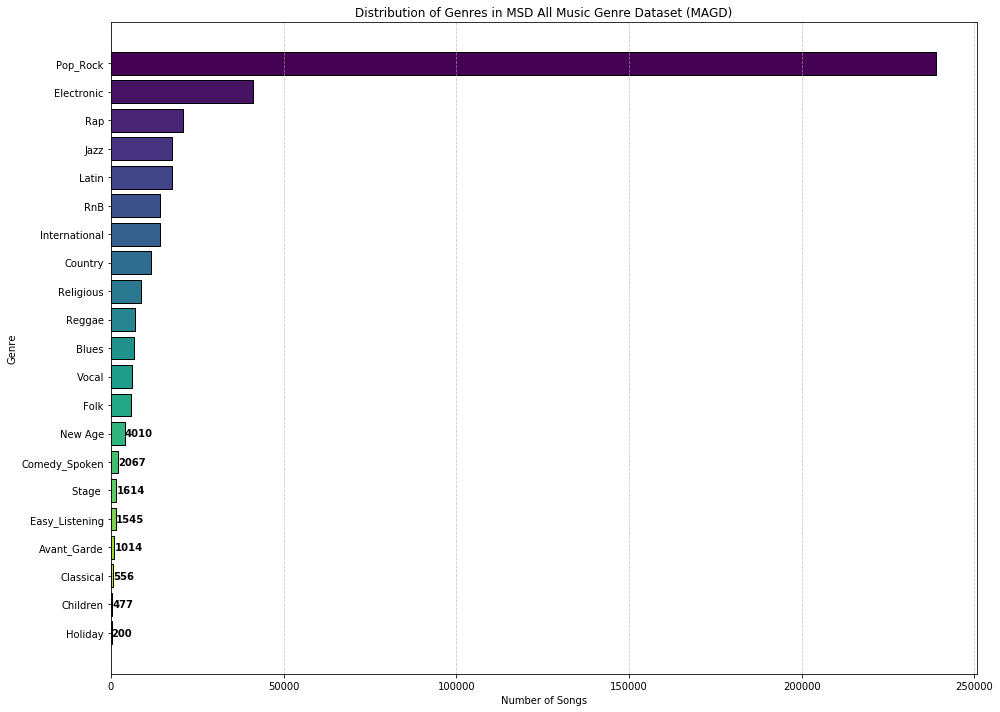

In [32]:
# Plot
plt.figure(figsize=(14, 10))

colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))

sorted_indexes = np.argsort(counts)  
genres_sorted = np.array(genres)[sorted_indexes]
counts_sorted = np.array(counts)[sorted_indexes]
colors_sorted = np.array(colors)[sorted_indexes]

plt.barh(genres_sorted, counts_sorted, color=colors_sorted, edgecolor='black')  


for index, value in enumerate(counts_sorted):
    if value < 5000: 
        plt.text(value, genres_sorted[index], str(value), va='center', fontweight='bold', color='black')

plt.xlabel('Number of Songs')
plt.ylabel('Genre')
plt.title('Distribution of Genres in MSD All Music Genre Dataset (MAGD)')
plt.grid(axis='x', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show()


### (c)

In [28]:
# Remove the single quotation mark from the MSD_TRACKID and rename it to track_id
selected_dataset_cleaned = selected_dataset.withColumn("track_id", regexp_replace(col("MSD_TRACKID"), "'", "")).drop("MSD_TRACKID")


In [29]:
# Merge the cleaned selected_dataset with genres_MAGD on track_id
merged_dataset = (
    selected_dataset_cleaned
    .join(
        genres_MAGD,
        on = "track_id",
        how = "left"
    )
    .where(F.col("genre").isNotNull())
    .dropDuplicates()
)

In [30]:
show_as_html(merged_dataset)

,track_id,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,genre
0,TRAAABD128F429CF47,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,67790.0,8281000.0,Pop_Rock
1,TRAAGTO128F1497E3C,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,157700.0,27380000.0,Pop_Rock
2,TRAAHAU128F9313A3D,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,198400.0,33360000.0,Pop_Rock
3,TRAAHZP12903CA25F4,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,196600.0,33550000.0,Rap
4,TRAAICW128F1496C68,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,189400.0,31560000.0,International
5,TRAAMFF12903CE8107,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,163800.0,27200000.0,Pop_Rock
6,TRAAMHG128F92ED7B2,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,183200.0,30590000.0,International
7,TRAAROH128F42604B0,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,169100.0,28290000.0,Electronic
8,TRAAUIH128F4254C9D,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,174800.0,29860000.0,Reggae
9,TRAAUQF12903CC4A4D,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,130100.0,17830000.0,Pop_Rock


## Q2

### (a)

Answer in Report

### (b)

In [31]:
# Convert the genre column to a binary column where "Electronic" is 1 and all other genres are 0
merged_dataset = merged_dataset.withColumn('is_electronic', F.when(F.col('genre') == 'Electronic', 1).otherwise(0))

# Compute the class balance
class_balance = merged_dataset.groupBy('is_electronic').count().collect()

# Extracting counts
electronic_count = next(row['count'] for row in class_balance if row['is_electronic'] == 1)
non_electronic_count = next(row['count'] for row in class_balance if row['is_electronic'] == 0)

# Displaying class balance
print(f'Electronic songs count: {electronic_count}')
print(f'Other genres songs count: {non_electronic_count}')


Electronic songs count: 40666
Other genres songs count: 379954


In [64]:
merged_dataset.show()

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-------------+-------------+
|          track_id|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|        genre|is_electronic|
+------------------+----------------------------------------------+-----

In [32]:
electronic_count = 40666
non_electronic_count = 379954

# Calculate total number of songs
total_songs = electronic_count + non_electronic_count

# Calculate percentage of Electronic songs
electronic_percentage = (electronic_count / total_songs) * 100

# Calculate percentage of songs from other genres
non_electronic_percentage = (non_electronic_count / total_songs) * 100

# Print results
print(f'Percentage of Electronic songs: {electronic_percentage:.2f}%')
print(f'Percentage of songs from other genres: {non_electronic_percentage:.2f}%')


Percentage of Electronic songs: 9.67%
Percentage of songs from other genres: 90.33%


### (c)

In [33]:
# Exact stratification using Window
temp = (
    merged_dataset
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())
    .withColumn(
        "row",
        F.row_number().over(
            Window.partitionBy("is_electronic").orderBy("random")
        )
    )
)

training_fraction = 0.8
train = temp.where(
    ((F.col("is_electronic") == 0) & (F.col("row") < non_electronic_count * training_fraction)) |
    ((F.col("is_electronic") == 1) & (F.col("row") < electronic_count * training_fraction))
)
train.cache()

test = temp.join(train, on="id", how="left_anti")
test.cache()

train = train.drop("id", "random", "row")
test = test.drop("id", "random", "row")

In [34]:
# Define the columns to be used as features
feature_cols = [col for col in train.columns if 'M' in col]  
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

# Use the StandardScaler to standardize the feature vectors,
standardizer = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
scaler_model = standardizer.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

# Replacing features with the scaled version
train = train.drop("features").withColumnRenamed("scaled_features", "features")
test = test.drop("features").withColumnRenamed("scaled_features", "features")

In [35]:
# Counts for upsampling
counts = {
    label: count for label, count in train.groupBy("is_electronic").count().collect()
}

# Upsampling via poisson random sampling
count_lower_bound = non_electronic_count
count_upper_bound = 2 * non_electronic_count 

def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))
    
    return [1]

random_resample_udf = F.udf(
    lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
    ArrayType(IntegerType())
)

train_resampled = (
    train
    .withColumn("rand", F.rand())
    .withColumn("sample", random_resample_udf(F.col("is_electronic"), F.col("rand")))
    .select(
        "*",
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)


In [36]:
# Helper function
def print_class_balance(data, name):
    """Print the class balance"""

    total = data.count()
    counts = data.groupBy("is_electronic").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'{name}')
    print(f'total: {total}')
    print(f'counts:')
    print(counts)
    print(f'')

In [37]:
print_class_balance(train_resampled, "train_resampled")

train_resampled
total: 759725
counts:
   is_electronic   count     ratio
0              1  379409  0.499403
1              0  379859  0.499995



### (d) (e)

### Logistic Regression Model

In [38]:
# Setting up the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='is_electronic')

# Training the model on the upsampled training data
lrModel = lr.fit(train_resampled)

In [39]:
# Helper function
def print_metrics(pred, labelCol="is_electronic", predictionCol="prediction", rawPredictionCol="rawPrediction"):
    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0

    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP:        {TP}')
    print(f'FP:        {FP}')
    print(f'FN:        {FN}')
    print(f'TN:        {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')


In [40]:
lrPred = lrModel.transform(test)
lrPred.cache()

print_metrics(lrPred)

total:     84125

nP actual: 8134
nN actual: 75991

nP:        29337
nN:        54788

TP:        5880
FP:        23457
FN:        2254
TN:        52534

precision: 0.20042949
recall:    0.72289157
accuracy:  0.69437147

auroc:     0.77385195


### Random Forest

In [41]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'is_electronic')
rfModel = rf.fit(train_resampled)

In [42]:
rfPred = rfModel.transform(test)
rfPred.cache()

print_metrics(rfPred)

total:     84125

nP actual: 8134
nN actual: 75991

nP:        26496
nN:        57629

TP:        5758
FP:        20738
FN:        2376
TN:        55253

precision: 0.21731582
recall:    0.70789280
accuracy:  0.72524220

auroc:     0.78940925


### Gradient-Boosted Tree

In [43]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'is_electronic')
gbtModel = gbt.fit(train_resampled)

In [44]:
gbtPred = gbtModel.transform(test)
gbtPred.cache()

print_metrics(gbtPred)

total:     84125

nP actual: 8134
nN actual: 75991

nP:        24733
nN:        59392

TP:        5716
FP:        19017
FN:        2418
TN:        56974

precision: 0.23110824
recall:    0.70272928
accuracy:  0.74520059

auroc:     0.81123127


### (f)

## Q3

### (a)

In [48]:
# Check the main hyperparameter settings of Logistic Regression
print("elasticNetParam:", lr.getElasticNetParam())
print("family:", lr.getFamily())
print("fitIntercept:", lr.getFitIntercept())
print("maxIter:", lr.getMaxIter())
print("regParam:", lr.getRegParam())
print("standardization:", lr.getStandardization())
print("threshold:", lr.getThreshold())


elasticNetParam: 0.0
family: auto
fitIntercept: True
maxIter: 100
regParam: 0.0
standardization: True
threshold: 0.5


In [49]:
# Check the main hyperparameter settings of Random Forest
print("numTrees:", rf.getNumTrees())
print("maxDepth:", rf.getMaxDepth())
print("maxBins:", rf.getMaxBins())
print("minInstancesPerNode:", rf.getMinInstancesPerNode())
print("minInfoGain:", rf.getMinInfoGain())
print("featureSubsetStrategy:", rf.getFeatureSubsetStrategy())
print("subsamplingRate:", rf.getSubsamplingRate())


numTrees: 20
maxDepth: 5
maxBins: 32
minInstancesPerNode: 1
minInfoGain: 0.0
featureSubsetStrategy: auto
subsamplingRate: 1.0


In [50]:
# Check the main hyperparameter settings of Gradient-Boosted Tree
print("maxDepth:", gbt.getMaxDepth())
print("maxBins:", gbt.getMaxBins())
print("minInstancesPerNode:", gbt.getMinInstancesPerNode())
print("minInfoGain:", gbt.getMinInfoGain())
print("maxIter:", gbt.getMaxIter())
print("stepSize:", gbt.getStepSize())
print("subsamplingRate:", gbt.getSubsamplingRate())
print("featureSubsetStrategy:", gbt.getFeatureSubsetStrategy())
print("lossType:", gbt.getLossType())


maxDepth: 5
maxBins: 32
minInstancesPerNode: 1
minInfoGain: 0.0
maxIter: 20
stepSize: 0.1
subsamplingRate: 1.0
featureSubsetStrategy: all
lossType: logistic


### (b)

### Logistic Regression Model

In [51]:
# Define the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='is_electronic')

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [20, 50, 100]) \
    .addGrid(lr.regParam, [0, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) \
    .build()

# Define the cross-validation setup
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='is_electronic'),
                          numFolds=5)  

# Run cross-validation
cvModel = crossval.fit(train_resampled)

pred = cvModel.transform(test)

print_metrics(pred)

total:     84125

nP actual: 8134
nN actual: 75991

nP:        29298
nN:        54827

TP:        5884
FP:        23414
FN:        2250
TN:        52577

precision: 0.20083282
recall:    0.72338333
accuracy:  0.69493016

auroc:     0.77372852


In [52]:
# Retrieve the best model
best_model = cvModel.bestModel

In [53]:
print(best_model.coefficients)

[0.47838047499229785,0.6462194571461561,-0.4966691059042962,-0.6253404067555186,0.7447016106283803,-0.3054840628423536,-2.7026806111596926,3.7411034532084373,-4.469478425025707,3.169596709707568]


In [56]:
print(best_model.explainParam(best_model.regParam))
print(best_model.explainParam(best_model.elasticNetParam))
print(best_model.explainParam(best_model.maxIter))

regParam: regularization parameter (>= 0). (default: 0.0, current: 0.0)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.2)
maxIter: max number of iterations (>= 0). (default: 100, current: 50)


### Random Forest

In [57]:
rf = RandomForestClassifier(featuresCol='features', labelCol='is_electronic')

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .build()

evaluator= BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='is_electronic', metricName="areaUnderROC")


crossval_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=5)

cvModel_rf = crossval_rf.fit(train_resampled)

pred_rf = cvModel_rf.transform(test)

print_metrics(pred_rf)

total:     84125

nP actual: 8134
nN actual: 75991

nP:        23447
nN:        60678

TP:        5771
FP:        17676
FN:        2363
TN:        58315

precision: 0.24612957
recall:    0.70949103
accuracy:  0.76179495

auroc:     0.81783244


In [60]:
best_model_rf = cvModel_rf.bestModel

print(best_model_cv.explainParam(best_model_cv.numTrees))

print(best_model_cv.explainParam(best_model_cv.maxDepth))

numTrees: Number of trees to train (>= 1). (default: 20, current: 30)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 10)


### Gradient-Boosted Tree

In [59]:
gbt = GBTClassifier(featuresCol='features', labelCol='is_electronic')

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .addGrid(gbt.maxDepth, [3, 5, 10]) \
    .build()

evaluator= BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='is_electronic', metricName="areaUnderROC")

crossval_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator,
    numFolds=5)

cvModel_gbt = crossval_gbt.fit(train_resampled)

pred_gbt = cvModel_gbt.transform(test)

print_metrics(pred_gbt)

total:     84125

nP actual: 8134
nN actual: 75991

nP:        20275
nN:        63850

TP:        5494
FP:        14781
FN:        2640
TN:        61210

precision: 0.27097411
recall:    0.67543644
accuracy:  0.79291530

auroc:     0.81783071


In [62]:
best_model_gbt = cvModel_gbt.bestModel

print(best_model_gbt.explainParam(best_model_gbt.maxIter))
 
print(best_model_gbt.explainParam(best_model_gbt.maxDepth))

maxIter: max number of iterations (>= 0). (default: 20, current: 50)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5, current: 10)


## Q4

### (b)

In [65]:
#Data Proccessing
feature_cols = [col for col in merged_dataset.columns if 'Method_of_Moments' in col]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
merged_dataset = assembler.transform(merged_dataset)

# Use the StandardScaler to standardize the feature vectors
standardizer = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
scaler_model = standardizer.fit(merged_dataset)
merged_dataset = scaler_model.transform(merged_dataset)

# Replacing features with the scaled version
merged_dataset = merged_dataset.drop("features").withColumnRenamed("scaled_features", "features")

In [67]:
merged_dataset.show()

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-------------+-------------+--------------------+
|          track_id|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|        genre|is_electronic|            features|
+------------------+----------

In [69]:
# Create the indexer
indexer = StringIndexer(inputCol="genre", outputCol="genre_index")

# Fit the indexer to the data
indexed = indexer.fit(merged_dataset).transform(merged_dataset)

# Show the indexed genre along with the original genre
indexed.select("genre", "genre_index").distinct().show()

multiclass_dataset = indexed

+--------------+-----------+
|         genre|genre_index|
+--------------+-----------+
|           Rap|        2.0|
|   Avant_Garde|       17.0|
|           RnB|        5.0|
|    Electronic|        1.0|
| International|        6.0|
|      Pop_Rock|        0.0|
|        Stage |       15.0|
|         Blues|       10.0|
|          Jazz|        3.0|
|       New Age|       13.0|
|      Children|       19.0|
|          Folk|       12.0|
|     Classical|       18.0|
|     Religious|        8.0|
|         Latin|        4.0|
|         Vocal|       11.0|
|        Reggae|        9.0|
| Comedy_Spoken|       14.0|
|Easy_Listening|       16.0|
|       Holiday|       20.0|
+--------------+-----------+
only showing top 20 rows



In [71]:
# Cast the double type index to integer type
multiclass_dataset = indexed.withColumn("genre_index", col("genre_index").cast("int"))

# Show the results
multiclass_dataset.select("genre", "genre_index").distinct().show()


+--------------+-----------+
|         genre|genre_index|
+--------------+-----------+
|         Vocal|         11|
|           RnB|          5|
|     Classical|         18|
|       Holiday|         20|
|      Pop_Rock|          0|
|Easy_Listening|         16|
|         Blues|         10|
|         Latin|          4|
|           Rap|          2|
|        Reggae|          9|
|      Children|         19|
|       New Age|         13|
|    Electronic|          1|
|     Religious|          8|
|          Jazz|          3|
|          Folk|         12|
| International|          6|
|       Country|          7|
| Comedy_Spoken|         14|
|        Stage |         15|
+--------------+-----------+
only showing top 20 rows



In [72]:
multiclass_dataset.show()

+------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-------------+-------------+--------------------+-----------+
|          track_id|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|        genre|is_electronic|            features|genre_index|
+-----

### (c)

In [84]:
# Helper function
def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("genre_index").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

In [87]:
def MultiClass_Split(data, label_col="genre_index"):
    """
    Split multiclass dataset into training and test set with stratified sampling.
    """
    # Assign a unique ID and random number to each row
    temp = (
        data
        .withColumn("id", F.monotonically_increasing_id())
        .withColumn("random", F.rand())
        .withColumn(
            "row",
            F.row_number()
            .over(
                Window
                .partitionBy(label_col)
                .orderBy("random")
            )
        )
    )

    # Get counts of each class
    counts = (
        data
        .groupBy(label_col)
        .count()
        .toPandas()
        .set_index(label_col)["count"]
        .to_dict()
    )
    
    labels = sorted(counts.keys())

    # Filter out 80% of data for training for each class
    multi_training = temp
    for label in labels:
        multi_training = multi_training.where((F.col(label_col) != label) | (F.col("row") < counts[label] * 0.8))
    
    multi_training.cache()

    # Rest 20% data for testing
    multi_test = temp.join(multi_training, on="id", how="left_anti")
    
    multi_test.cache()

    multi_training = multi_training.drop("id", "random", "row")
    multi_test = multi_test.drop("id", "random", "row")
    
    return multi_training, multi_test

# Using the function
train_data, test_data = MultiClass_Split(multiclass_dataset)

In [88]:
counts = {label: count for label, count in train_data.groupBy("genre_index").count().collect()}
print(counts)


{12: 4631, 18: 443, 10: 5440, 1: 32532, 3: 14219, 20: 159, 13: 3199, 14: 1653, 6: 11355, 9: 5544, 7: 9352, 11: 4945, 0: 190119, 8: 7023, 16: 1227, 5: 11451, 2: 16719, 17: 809, 15: 1290, 19: 370, 4: 14003}


In [89]:
counts_values = [4631, 443, 5440, 32532, 14219, 159, 3199, 1653, 11355, 5544, 9352, 4945, 190119, 7023, 1227, 11451, 16719, 809, 1290, 370, 14003]

# Calculate the median
median_value = int(np.median(counts_values))

# Calculate the 75th percentile
percentile_75_value = int(np.percentile(counts_values, 75))

print("Median Value (50th percentile):", median_value)
print("75th Percentile Value:", percentile_75_value)


Median Value (50th percentile): 5440
75th Percentile Value: 11451


In [90]:
# Upsampling via poisson random sampling

count_lower_bound = median_value
count_upper_bound = percentile_75_value

def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if y < (count_upper_bound / count): # randomly downsample to count_upper_bound
            return [1]
        else:
            return []

    return [1]  # do nothing

random_resample_udf = F.udf(
    lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
    ArrayType(IntegerType())
)
training_resampled = (
    train_data
    .withColumn("rand", F.rand())
    .withColumn("sample", random_resample_udf(F.col("genre_index"), F.col("rand")))
    .select(
        F.col("track_id"),
        F.col("genre_index"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")  # note that explode on [] will effectively drop the row
    )
    .drop("sample")
)

In [97]:
print_class_balance(training_resampled, 'training_resampled')

dataset: training_resampled
total:   161671
counts:
    genre_index  count     ratio
0            12   5444  0.033673
1            18   5424  0.033550
2            10   5440  0.033649
3             1  11477  0.070990
4             3  11451  0.070829
5            20   5327  0.032950
6            13   5450  0.033710
7            14   5321  0.032913
8             6  11355  0.070235
9             9   5544  0.034292
10            7   9352  0.057846
11           11   5417  0.033506
12            0  11286  0.069808
13            8   7023  0.043440
14           16   5409  0.033457
15            5  11451  0.070829
16            2  11439  0.070755
17           17   5434  0.033611
18           15   5309  0.032838
19           19   5370  0.033216
20            4  11438  0.070749



In [98]:
multi_lr = LogisticRegression(featuresCol='features', labelCol='genre_index')
multi_lr_model = multi_lr.fit(training_resampled)
multi_lr_pred = multi_lr_model.transform(test_data)
multi_lr_pred.cache()

DataFrame[track_id: string, Method_of_Moments_Overall_Standard_Deviation_1: double, Method_of_Moments_Overall_Standard_Deviation_2: double, Method_of_Moments_Overall_Standard_Deviation_3: double, Method_of_Moments_Overall_Standard_Deviation_4: double, Method_of_Moments_Overall_Standard_Deviation_5: double, Method_of_Moments_Overall_Average_1: double, Method_of_Moments_Overall_Average_2: double, Method_of_Moments_Overall_Average_3: double, Method_of_Moments_Overall_Average_4: double, Method_of_Moments_Overall_Average_5: double, genre: string, is_electronic: int, features: vector, genre_index: int, rawPrediction: vector, probability: vector, prediction: double]

In [99]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="genre_index", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(multi_lr_pred)
print(f"Test Accuracy = {accuracy}")

# Calculate precision by label
precision = evaluator.evaluate(
    multi_lr_pred, {evaluator.metricName: "weightedPrecision"}
)
print(f"Weighted Precision = {precision}")

# Calculate recall by label
recall = evaluator.evaluate(
    multi_lr_pred, {evaluator.metricName: "weightedRecall"}
)
print(f"Weighted Recall = {recall}")

# Calculate F1 score by label
f1 = evaluator.evaluate(multi_lr_pred, {evaluator.metricName: "f1"})
print(f"Weighted F1 Score = {f1}")



Test Accuracy = 0.3446997159394797
Weighted Precision = 0.5500838168720563
Weighted Recall = 0.3446997159394797
Weighted F1 Score = 0.39489551994146727


# Song recommendations

## Q1

### (a)

In [14]:
# Repartitioning and Caching
num_executors = 4
num_cores_per_executor = 2
optimal_partitions = num_executors * num_cores_per_executor * 4  # Rough heuristic

triplets_not_mismatched_repartitioned = triplets_not_mismatched.repartition(optimal_partitions).cache()

### (b)

In [15]:
unique_songs_count = triplets_not_mismatched_repartitioned.select("song_id").distinct().count()
unique_users_count = triplets_not_mismatched_repartitioned.select("user_id").distinct().count()

print("Number of unique songs:", unique_songs_count)
print("Number of unique users:", unique_users_count)


Number of unique songs: 378310
Number of unique users: 1019318


### (c)

In [16]:
# Identify the most active user
most_active_user = (
    triplets_not_mismatched_repartitioned.groupBy("user_id")
    .count()
    .orderBy("count", ascending=False)
    .limit(1)
    .collect()[0]["user_id"]
)

# Calculate the number of different songs played by this user
num_songs_played_by_user = (
    triplets_not_mismatched_repartitioned.filter(triplets_not_mismatched_repartitioned.user_id == most_active_user)
    .select("song_id")
    .distinct()
    .count()
)

# Calculate the total number of unique songs in the dataset
total_unique_songs = triplets_not_mismatched_repartitioned.select("song_id").distinct().count()

# Calculate the percentage of songs played by this user relative to the total number of songs
percentage_played = (num_songs_played_by_user / total_unique_songs) * 100

print(f"The most active user has played {num_songs_played_by_user} different songs.")
print(f"This is {percentage_played:.2f}% of the total number of unique songs in the dataset.")


The most active user has played 4316 different songs.
This is 1.14% of the total number of unique songs in the dataset.


### (d)

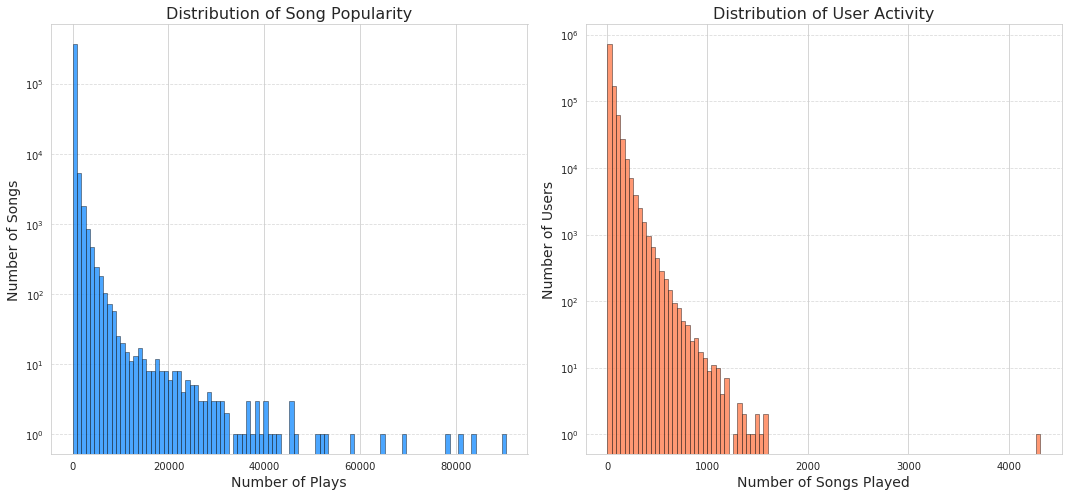

In [17]:
sns.set_style("whitegrid")

# 1. Distribution of song popularity
song_popularity = (triplets_not_mismatched_repartitioned.groupBy("song_id")
                   .agg(F.count("user_id").alias("num_plays"))
                   .orderBy("num_plays", ascending=False)
                   .toPandas())

# 2. Distribution of user activity
user_activity = (triplets_not_mismatched_repartitioned.groupBy("user_id")
                 .agg(F.count("song_id").alias("num_songs_played"))
                 .orderBy("num_songs_played", ascending=False)
                 .toPandas())

# Visualization
plt.figure(figsize=(15, 7))

# Song popularity distribution
plt.subplot(1, 2, 1)
plt.hist(song_popularity["num_plays"], bins=100, log=True, color='dodgerblue', alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title("Distribution of Song Popularity", fontsize=16)
plt.xlabel("Number of Plays", fontsize=14)
plt.ylabel("Number of Songs", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# User activity distribution
plt.subplot(1, 2, 2)
plt.hist(user_activity["num_songs_played"], bins=100, log=True, color='coral', alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title("Distribution of User Activity", fontsize=16)
plt.xlabel("Number of Songs Played", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Q2

### (a)

In [18]:
# Calculate the 25% quantile for song plays and user activity
N = song_popularity["num_plays"].quantile(0.25)
M = user_activity["num_songs_played"].quantile(0.25)

print(f"N = {N}")
print(f"M = {M}")

N = 4.0
M = 15.0


In [19]:
# Filter songs played less than N times
songs_above_threshold = (triplets_not_mismatched_repartitioned.groupBy("song_id")
                         .agg(F.count("user_id").alias("num_plays"))
                         .filter(F.col("num_plays") >= N)
                         .select("song_id"))

# Filter users who have listened to fewer than M songs in total
users_above_threshold = (triplets_not_mismatched_repartitioned.groupBy("user_id")
                         .agg(F.count("song_id").alias("num_songs_played"))
                         .filter(F.col("num_songs_played") >= M)
                         .select("user_id"))

# Join the dataframes to get the cleaned dataset
cleaned_data = (triplets_not_mismatched_repartitioned.join(songs_above_threshold, "song_id", "inner")
                .join(users_above_threshold, "user_id", "inner"))

# Show the cleaned data
cleaned_data.show()

+--------------------+------------------+-----+
|             user_id|           song_id|plays|
+--------------------+------------------+-----+
|00007f902e31b0693...|SOWYYUQ12A6701D68D|   11|
|00007f902e31b0693...|SOWTZWQ12AB0188079|    1|
|00007f902e31b0693...|SOAUUQZ12A6310E8C4|    1|
|00007f902e31b0693...|SOUUPZA12A8C136429|    1|
|00007f902e31b0693...|SOBKLTU12A58A7FB77|    4|
|00007f902e31b0693...|SOOXPPN12AB0180907|   14|
|00007f902e31b0693...|SOODVNE12AB018D4EA|    3|
|00007f902e31b0693...|SOIGXKF12A6701E096|    3|
|00007f902e31b0693...|SOLAIVS12A6D4FA40A|   13|
|00007f902e31b0693...|SOTAVJH12A67020D8C|    2|
|00007f902e31b0693...|SODZJCH12A8C132ADC|    4|
|00007f902e31b0693...|SOGPBAW12A6D4F9F22|    3|
|00007f902e31b0693...|SOSRJRK12AB0186FF4|    1|
|00007f902e31b0693...|SOTQUEC12AB01877F8|    1|
|00007f902e31b0693...|SOMPFYJ12A6D4FC4FB|    3|
|00007f902e31b0693...|SOKKFVZ12A58A7A8B0|    1|
|00007f902e31b0693...|SOPBPCY12AF72A827F|    2|
|00007f902e31b0693...|SODIKCN12A8C144F32

### (b)

In [26]:
# For each user, split their song plays into training and test sets
train_data = cleaned_data.withColumn("random_val", rand(seed=42))

# For each user, assign 75% of their song plays to the training set
train_data = train_data.filter(F.col("random_val") <= 0.75)

# The rest (25%) goes to the test set
test_data = cleaned_data.join(train_data, ["user_id", "song_id"], "leftanti")

# Drop the random column
train_data = train_data.drop("random_val")
test_data = test_data.drop("random_val")

# Show the datasets
train_data.show()
test_data.show()


+--------------------+------------------+-----+
|             user_id|           song_id|plays|
+--------------------+------------------+-----+
|00007f902e31b0693...|SOODVNE12AB018D4EA|    3|
|00007f902e31b0693...|SOTAVJH12A67020D8C|    2|
|00007f902e31b0693...|SOTQUEC12AB01877F8|    1|
|00007f902e31b0693...|SODIKCN12A8C144F32|    2|
|00007f902e31b0693...|SOUUPZA12A8C136429|    1|
|00007f902e31b0693...|SOOXPPN12AB0180907|   14|
|00007f902e31b0693...|SOPUDWU12A8AE4612A|    1|
|00007f902e31b0693...|SOKKFVZ12A58A7A8B0|    1|
|00007f902e31b0693...|SOPBPCY12AF72A827F|    2|
|00007f902e31b0693...|SOIGXKF12A6701E096|    3|
|00007f902e31b0693...|SOLAIVS12A6D4FA40A|   13|
|00007f902e31b0693...|SOMPFYJ12A6D4FC4FB|    3|
|00007f902e31b0693...|SODZJCH12A8C132ADC|    4|
|00007f902e31b0693...|SOGPBAW12A6D4F9F22|    3|
|0003da5cfb2cd65da...|SOMPGOD12A8C13F706|    1|
|0003da5cfb2cd65da...|SOOEGYT12A58A7AF78|    1|
|0003da5cfb2cd65da...|SOGOSHO12AB0184D38|    1|
|0003da5cfb2cd65da...|SOXVKHM12AB0181125

### (c)

In [27]:
# Convert 'user_id' and 'song_id' to numeric values using StringIndexer

user_id_indexer = StringIndexer(inputCol="user_id", outputCol="user_id_encoded")
song_id_indexer = StringIndexer(inputCol="song_id", outputCol="song_id_encoded")

user_id_indexer_model = user_id_indexer.fit(cleaned_data)  # Note: fit on the entire dataset for consistent encoding
song_id_indexer_model = song_id_indexer.fit(cleaned_data)

train_data = user_id_indexer_model.transform(train_data)
train_data = song_id_indexer_model.transform(train_data)

test_data = user_id_indexer_model.transform(test_data)
test_data = song_id_indexer_model.transform(test_data)

In [28]:
# Set up ALS parameters
als = ALS(maxIter=5, regParam=0.01, userCol="user_id_encoded", itemCol="song_id_encoded", ratingCol="plays", implicitPrefs=True)

# Train the ALS model
als_model = als.fit(train_data)

# Make predictions
pred = als_model.transform(test_data)
pred.cache()

DataFrame[user_id: string, song_id: string, plays: int, user_id_encoded: double, song_id_encoded: double, prediction: float]

### (d) 

In [29]:
# Identify top 5 users with the most song plays in the test data
top_users_test = (test_data.groupBy("user_id_encoded")
                 .agg(F.count("song_id_encoded").alias("num_songs_played"))
                 .orderBy("num_songs_played", ascending=False)
                 .limit(5)
                 .collect())

selected_user_ids = [row.user_id_encoded for row in top_users_test]

In [30]:
number_of_recommendations = 10
recommendations = als_model.recommendForUserSubset(test_data.filter(F.col("user_id_encoded").isin(selected_user_ids)), number_of_recommendations)

In [31]:
# Unpack the recommendations
recommended_songs = recommendations.withColumn("rec", explode(F.col("recommendations"))).select("user_id_encoded", "rec.song_id_encoded", "rec.rating")

for user_id in selected_user_ids:
    played_songs = test_data.filter(F.col("user_id_encoded") == user_id).select("song_id_encoded").distinct().collect()
    rec_songs = recommended_songs.filter(F.col("user_id_encoded") == user_id).select("song_id_encoded").distinct().collect()
    
    # Convert played songs and recommended songs into sets for easier comparison
    played_song_ids = {row.song_id_encoded for row in played_songs}
    rec_song_ids = {row.song_id_encoded for row in rec_songs}
    
    # Find overlap between played songs and recommended songs
    overlap_songs = played_song_ids.intersection(rec_song_ids)
    
    print(f"User {user_id}:")
    print("Songs played:", played_song_ids)
    print("Recommended songs:", rec_song_ids)
    print("Overlapping songs:", overlap_songs)
    print("Number of overlapping songs:", len(overlap_songs))
    print("-" * 40)


User 0.0:
Songs played: {12289.0, 235522.0, 280584.0, 204812.0, 65550.0, 32783.0, 26640.0, 24592.0, 266258.0, 8212.0, 126996.0, 59414.0, 129047.0, 67608.0, 10265.0, 219162.0, 22554.0, 8220.0, 104477.0, 223259.0, 67576.0, 81953.0, 110631.0, 98344.0, 12331.0, 67629.0, 75822.0, 198702.0, 18483.0, 182326.0, 22584.0, 14393.0, 53306.0, 10300.0, 12354.0, 292930.0, 61508.0, 4171.0, 153683.0, 65622.0, 34902.0, 295000.0, 100441.0, 245849.0, 82008.0, 55388.0, 63583.0, 2154.0, 107.0, 24684.0, 90221.0, 79987.0, 145524.0, 69749.0, 77942.0, 4218.0, 41097.0, 39052.0, 145551.0, 145.0, 47252.0, 8341.0, 30878.0, 112800.0, 47265.0, 30888.0, 96427.0, 65715.0, 88244.0, 34999.0, 192696.0, 131256.0, 28859.0, 35004.0, 143552.0, 121026.0, 195.0, 75971.0, 39107.0, 43206.0, 26824.0, 43210.0, 30924.0, 53455.0, 24785.0, 86229.0, 147673.0, 82138.0, 90331.0, 84187.0, 71901.0, 24798.0, 35038.0, 114911.0, 223458.0, 229603.0, 82148.0, 18661.0, 47334.0, 55526.0, 30951.0, 110821.0, 47333.0, 63723.0, 4333.0, 41198.0, 92401

User 3.0:
Songs played: {0.0, 34817.0, 2.0, 10243.0, 4.0, 5.0, 8198.0, 28678.0, 18441.0, 10.0, 100363.0, 12.0, 13.0, 4108.0, 15.0, 2065.0, 133138.0, 22.0, 45080.0, 86044.0, 8225.0, 2081.0, 20518.0, 48.0, 51251.0, 56.0, 60.0, 4157.0, 6204.0, 22589.0, 2112.0, 69.0, 70.0, 2118.0, 30790.0, 71.0, 24650.0, 78.0, 36943.0, 79.0, 2127.0, 43093.0, 4191.0, 98403.0, 59492.0, 10341.0, 4213.0, 122.0, 126.0, 77957.0, 143.0, 26768.0, 20632.0, 155.0, 2206.0, 4254.0, 168.0, 169.0, 4274.0, 2228.0, 181.0, 92345.0, 18618.0, 4283.0, 112830.0, 190.0, 8386.0, 4291.0, 73933.0, 207.0, 2262.0, 24790.0, 214.0, 2266.0, 8412.0, 220.0, 14558.0, 18654.0, 222.0, 235.0, 16619.0, 8441.0, 43260.0, 10498.0, 4355.0, 266.0, 6418.0, 45338.0, 10525.0, 14621.0, 96545.0, 291.0, 293.0, 2356.0, 310.0, 14646.0, 4411.0, 12604.0, 317.0, 67905.0, 6466.0, 322.0, 324.0, 14662.0, 26951.0, 328.0, 26959.0, 354.0, 356.0, 26984.0, 20843.0, 371.0, 209275.0, 384.0, 386.0, 45448.0, 4492.0, 396.0, 2446.0, 16781.0, 6545.0, 2450.0, 404.0, 408.0, 

User 4.0:
Songs played: {2.0, 3.0, 24579.0, 8.0, 11.0, 6160.0, 17.0, 215063.0, 6171.0, 31.0, 8229.0, 39.0, 45.0, 6194.0, 8248.0, 57.0, 26688.0, 16448.0, 69.0, 77.0, 6228.0, 12375.0, 8283.0, 116827.0, 93.0, 2144.0, 98.0, 4195.0, 4198.0, 6247.0, 103.0, 114.0, 2176.0, 129.0, 28801.0, 131.0, 41093.0, 143.0, 154.0, 10399.0, 100518.0, 18599.0, 16556.0, 173.0, 177.0, 178.0, 10422.0, 2235.0, 8380.0, 16573.0, 190.0, 12478.0, 8384.0, 41158.0, 203.0, 2251.0, 4312.0, 216.0, 218.0, 219.0, 221.0, 2272.0, 243.0, 246.0, 2307.0, 4358.0, 267.0, 285.0, 290.0, 4387.0, 6436.0, 6448.0, 18745.0, 18762.0, 336.0, 43345.0, 20818.0, 8546.0, 104803.0, 199013.0, 357.0, 121192.0, 33145.0, 385.0, 388.0, 389.0, 399.0, 2451.0, 16788.0, 16801.0, 6571.0, 49597.0, 260543.0, 18880.0, 2498.0, 6596.0, 453.0, 16841.0, 22988.0, 460.0, 6608.0, 16854.0, 476.0, 479.0, 29154.0, 41444.0, 490.0, 492.0, 501.0, 503.0, 6654.0, 513.0, 20999.0, 39433.0, 37393.0, 533.0, 49698.0, 2597.0, 4647.0, 8744.0, 6707.0, 14903.0, 568.0, 10807.0, 39

### (e)

In [32]:
results = []

for user_id in selected_user_ids:
    played_songs = test_data.filter(F.col("user_id_encoded") == user_id).select("song_id_encoded").distinct().collect()
    rec_songs = recommended_songs.filter(F.col("user_id_encoded") == user_id).select("song_id_encoded").distinct().collect()
    
    played_song_ids = [row.song_id_encoded for row in played_songs]
    rec_song_ids = [row.song_id_encoded for row in rec_songs]

    results.append((user_id, played_song_ids, rec_song_ids))


In [33]:
# Convert results to a DataFrame
df_results = spark.createDataFrame([Row(user_id=r[0], relevant=r[1], recommendations=r[2]) for r in results])

In [34]:
# Convert the "recommendations" column to array<double>
df_results = df_results.withColumn("recommendations", col("recommendations").cast("array<double>"))

In [35]:
df_results.show(truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(df_results, {evaluator.metricName: "precisionAtK", evaluator.k: k})
mapAtK = evaluator.evaluate(df_results, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK = evaluator.evaluate(df_results, {evaluator.metricName: "ndcgAtK", evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')


metrics for implicit feedback

precision @ K: 0.12000
MAP @ K:       0.08810
NDCG @ K:      0.14944



In [21]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()